In [2525]:
import numpy as np
import matplotlib.pyplot as plt
import plot_settings
from collections import namedtuple
import matplotlib.pylab as pylab
import pickle

params = {'legend.fontsize': 10,
          'figure.figsize': (5.728, 3.54),
          'figure.dpi': 100,
          'axes.labelsize': 15,
          'axes.titlesize': 15,
          'xtick.labelsize': 10,
          'ytick.labelsize': 10}

pylab.rcParams.update(params)

colors = ['#e41a1c', '#377eb8', '#4daf4a', '#984ea3', '#ff7f00', '#FFDB58', '#a65628']
markers = ['o', "^", "v", "*", "+", "x", "s", "p"]
linestyles = ['-', '--', '-.', ':', '-', '--', ':', '-.']

In [2526]:
class HairField:
    def __init__(self, parameters):
        self.N_hairs = parameters['N_hairs']
        self.max_joint_angle = parameters['max_joint_angle']
        self.min_joint_angle = parameters['min_joint_angle']
        self.max_angle = parameters['max_angle']
        self.overlap = parameters['overlap']
        self.receptive_field = None

    def get_receptive_field(self):
        rf = (self.max_joint_angle - self.min_joint_angle) / self.N_hairs
        rf = (1-self.overlap/(self.max_joint_angle - self.min_joint_angle))*rf

        receptive_min = np.linspace(self.min_joint_angle, self.min_joint_angle + rf*(self.N_hairs - 1),
                                    num=self.N_hairs)

        receptive_max = np.linspace(self.max_joint_angle - rf*(self.N_hairs - 1), self.max_joint_angle,
                                    num=self.N_hairs)

        self.receptive_field = np.stack((receptive_min, receptive_max))
        
        
    def get_double_receptive_field(self):
        self.get_receptive_field()

        rf1 = -self.receptive_field.copy() + self.max_joint_angle + self.min_joint_angle

        self.receptive_field = np.hstack((rf1, self.receptive_field))
        self.N_hairs = 2 * self.N_hairs
        
    
    def reset_max_min(self, i):
        self.max_joint_angle = self.max_list[i]
        self.min_joint_angle = self.min_list[i]


    def get_hair_angle(self, x):
        min_rf = self.receptive_field[0, :]
        slope = self.max_angle / (self.receptive_field[1, :] - self.receptive_field[0, :])

        slope, min_rf, x = np.tile(slope, (x.size, 1)), np.tile(min_rf, (x.size, 1)), np.tile(x, (self.N_hairs, 1)).T

        out = np.maximum(slope * (x - self.receptive_field[0, :]), 0)
        out[out > 90] = 90

        return out

In [2527]:
parameters_hair_field = {'N_hairs': 10, 'max_joint_angle': 180, 'min_joint_angle': 0, 'max_angle': 90, 'overlap': 4}
joint_angle = np.linspace(-20, 200, num=2000)

hair_field = HairField(parameters_hair_field)
hair_field.get_receptive_field()
hair_angles = hair_field.get_hair_angle(joint_angle)

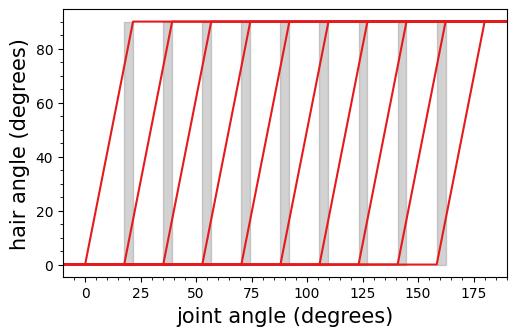

In [2528]:
fig, ax = plt.subplots()


plt.plot(joint_angle, hair_angles, color=colors[0], linestyle=linestyles[0])

for i in range(hair_field.N_hairs - 1):
    plt.fill_between([hair_field.receptive_field[0, 1+i], hair_field.receptive_field[1, i]], [90, 90], color='grey', alpha=0.35)

ax.set_xlabel("joint angle (degrees)")
ax.set_ylabel("hair angle (degrees)")
ax.set_xlim(-10, 190)
ax.minorticks_on()

In [2529]:
fig.tight_layout(pad=0.5)
fig.savefig('images/afferents/uni_hairplate.png')
fig.savefig('images/afferents/uni_hairplate.pdf')
fig.clear()

In [2530]:
parameters_hair_field = {'N_hairs': 10, 'max_joint_angle': 180, 'min_joint_angle': 0, 'max_angle': 90, 'overlap': 4}

hair_field = HairField(parameters_hair_field)
hair_field.get_receptive_field()
hair_field.get_double_receptive_field()
hair_angles = hair_field.get_hair_angle(joint_angle)

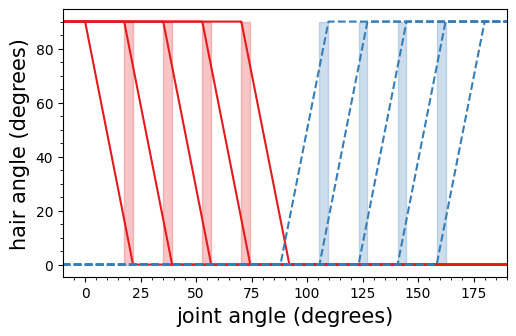

In [2531]:
fig, ax = plt.subplots()

n_2 = int(hair_field.N_hairs/2)
n_4 = int(n_2/2)

plt.plot(joint_angle, hair_angles[:, n_4:n_2], color=colors[0], linestyle=linestyles[0])
plt.plot(joint_angle, hair_angles[:, n_2+n_4:], color=colors[1], linestyle=linestyles[1])

for i in range(n_4 - 1):
    plt.fill_between([hair_field.receptive_field[0,  n_4 + i + 1], hair_field.receptive_field[1, n_4 + i]], [90, 90], 
                     color=colors[0],
                     alpha=0.25)
    plt.fill_between([hair_field.receptive_field[0, n_2 + n_4 + i + 1], hair_field.receptive_field[1, n_2 + n_4 + i]], [90, 90],
                     color=colors[1],
                     alpha=0.25,)
    
ax.set_xlabel("joint angle (degrees)")
ax.set_ylabel("hair angle (degrees)")
ax.set_xlim(-10, 190)
ax.minorticks_on()

In [2532]:
fig.tight_layout(pad=0.5)
fig.savefig('images/afferents/bi_hairplate_pos.png')
fig.savefig('images/afferents/bi_hairplate_pos.pdf')
fig.clear()

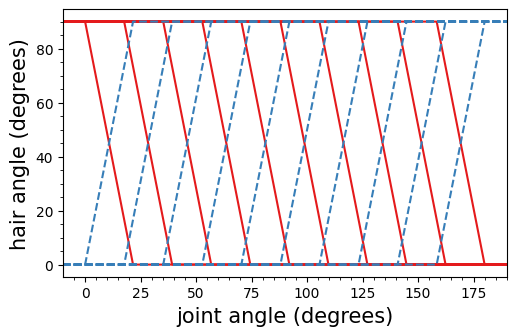

In [2533]:
fig, ax = plt.subplots()

plt.plot(joint_angle, hair_angles[:, :n_2], color=colors[0], linestyle=linestyles[0])
plt.plot(joint_angle, hair_angles[:, n_2:], color=colors[1], linestyle=linestyles[1])
    
ax.set_xlabel("joint angle (degrees)")
ax.set_ylabel("hair angle (degrees)")
ax.set_xlim(-10, 190)
ax.minorticks_on()

In [2534]:
fig.tight_layout(pad=0.5)
fig.savefig('images/afferents/bi_hairplate_vel.png')
fig.savefig('images/afferents/bi_hairplate_vel.pdf')
fig.clear()

In [2535]:
class SensoryNeuron:
    NeuronState = namedtuple('NeuronState', ['V', 'w', 'spk'])

    def __init__(self, parameters):
        super(SensoryNeuron, self).__init__()
        self.C = parameters['C']
        self.g_L = parameters['g_L']
        self.E_L = parameters['E_L']
        self.DeltaT = parameters['DeltaT']
        self.a = parameters['a']
        self.V_T = parameters['V_T']
        self.tau_W = parameters['tau_W']
        self.b = parameters['b']
        self.V_R = parameters['V_R']
        self.V_cut = parameters['V_cut']
        self.n = parameters['n']
        self.dt = parameters['dt']
        self.state = None

    def initialize_state(self):
        self.state = None

    def forward(self, input):
        if self.state is None:
            self.state = self.NeuronState(V=np.linspace(self.E_L, self.E_L+10e-3, self.n),
                                          w=np.zeros(self.n),
                                          spk=np.zeros(self.n))
        V = self.state.V
        w = self.state.w
        I = input

        V += (self.g_L * (self.E_L - V) + self.g_L * self.DeltaT * np.exp(
            (V - self.V_T) / self.DeltaT) - w + I) * self.dt / self.C

        spk = np.heaviside(V - self.V_cut, 0)
        
        V = (1 - spk) * V + spk * self.V_R
        
        w += spk * self.b
        w += (self.a * (V - self.E_L) - w) * self.dt / self.tau_W

        self.state = self.NeuronState(V=V, w=w, spk=spk)

        return V, spk

In [2536]:
def ramp_generator(n_ramp, n_steps, height, base=0):
    n_dims = height.size
    
    input_ramp = np.zeros((n_steps, n_dims))

    for i in range(n_dims):
        increase = np.linspace(base, height[i], n_ramp[i])
        constant = np.linspace(height[i], height[i], n_steps - 2 * n_ramp[i])
        decrease = np.linspace(height[i], base, n_ramp[i])
        
        input_ramp[:, i] = np.concatenate((increase, constant, decrease))
        
    return input_ramp

def get_firing_rate(spike_train, dt):
    spike_index = np.where(spike_train == 1)[0]

    if len(spike_index) > 1:
        inter_spike_interval = np.diff(spike_index) * dt
        firing_rate = 1 / inter_spike_interval
        firing_rate = np.append(firing_rate, firing_rate[-1])
        
        firing_rate = np.concatenate([[0], firing_rate, [0]])
        spike_index = np.concatenate([[0], spike_index, [spike_train.size-3]])
    else:
        firing_rate = np.array([])

    return firing_rate, spike_index

In [2537]:
sensory_parameters = {'C': 200e-12, 'g_L': 2e-9, 'E_L': -70e-3, 'DeltaT': 2e-3, 'a': 2e-9, 'V_T': -50e-3,
                      'tau_W': 50e-3, 'b': 264e-12, 'V_R': -70e-3, 'V_cut': -40e-3, 'n': 5, 'dt': 0.0001}

sensory_neuron = SensoryNeuron(sensory_parameters)
sensory_neuron.initialize_state()

In [2538]:
v_var, v_stat = np.array([24, 47, 88, 151, 245])*4, 60*4
max_angle_var, max_angle_stat = np.array([15, 23, 34, 46, 60]), 37
t_total = 3
j=0

N_steps = round(t_total/sensory_parameters['dt'])
time, spike_train = np.array([]), np.empty((N_steps + 2, v_var.size, 2))
for [v, max_angle] in [[v_var, max_angle_stat], [v_stat, max_angle_var]]:

    N_ramp = np.around(max_angle/(v*sensory_parameters['dt'])).astype(int)
    height = np.empty(sensory_parameters['n'])
    height[:] = max_angle/18e9
    
    input_ramp = ramp_generator(N_ramp, N_steps, height)

    sensory_neuron.initialize_state()

    for i in range(N_steps):
        _, spike_train[i, :, j] = sensory_neuron.forward(input_ramp[i])
        time = np.append(time, i*sensory_parameters['dt'])
        
    j +=1

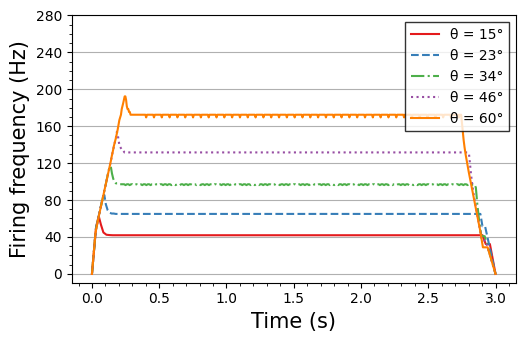

In [2539]:
fig, ax = plt.subplots()

for i in range(v_var.size):
    firing_rate, spike_index = get_firing_rate(spike_train[:, i, 1], sensory_parameters['dt'])
    ax.plot(time[spike_index], firing_rate, color=colors[i], linestyle=linestyles[i])

ax.set_xlabel("Time (s)")
ax.set_ylabel("Firing frequency (Hz)")
ax.grid(axis='y')
ax.legend(['θ = 15°', 'θ = 23°', 'θ = 34°', 'θ = 46°', 'θ = 60°'], fancybox=False, edgecolor='black')  
ax.set_yticks([0, 40, 80, 120, 160, 200, 240, 280])
ax.minorticks_on()

In [2540]:
fig.tight_layout(pad=0.5)
fig.savefig('images/afferents/single_hair_constant_angle.png')
fig.savefig('images/afferents/single_hair_constant_angle.pdf')

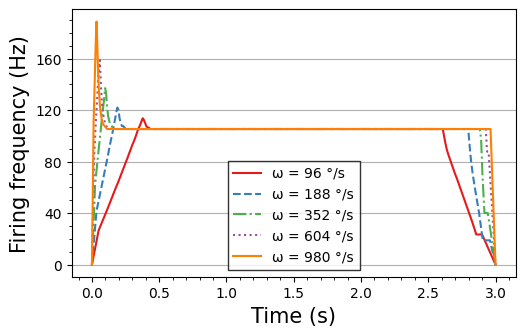

In [2541]:
fig, ax = plt.subplots()

for i in range(5):
    firing_rate, spike_index = get_firing_rate(spike_train[:, i, 0], sensory_parameters['dt'])
    plt.plot(time[spike_index], firing_rate, color=colors[i], linestyle=linestyles[i])

ax.set_xlabel("Time (s)")
ax.set_ylabel("Firing frequency (Hz)")
ax.grid(axis='y')
ax.legend(['ω = 96 °/s', 'ω = 188 °/s', 'ω = 352 °/s', 'ω = 604 °/s', 'ω = 980 °/s'], fancybox=False, edgecolor='black', loc='lower center')
ax.set_yticks([0, 40, 80, 120, 160])
ax.minorticks_on()

In [2542]:
fig.tight_layout(pad=0.5)
fig.savefig('images/afferents/single_hair_variable_angle.png')
fig.savefig('images/afferents/single_hair_variable_angle.pdf')

In [2543]:
with open('data/joint_angles_nostep', 'rb') as file:
    joint_angles_nostep = pickle.load(file)
    
print(joint_angles_nostep[0].shape)

(5000, 18)
